In [1]:
# import modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist # type: ignore
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU, Input, BatchNormalization, Softmax, Reshape, Activation, Concatenate # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from keras.callbacks import EarlyStopping

# from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt


In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# choose normalisation range for sigmoid vs tanh

# Normalize to between -1 and 1
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5
image_input_range = (-1, 1)

# train_images = (train_images) / 255
# test_images = (test_images) / 255
# image_input_range = (0, 1)

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
all_images = np.concatenate(
    (
        train_images,
        test_images
    ),
    axis=0
)

all_labels = np.concatenate(
    (
        train_labels,
        test_labels
    ),
    axis = 0
)

In [5]:
all_images.shape

(70000, 28, 28)

In [6]:
def show_mnist_images(all_images_data, current_range):
    # show some of the images we will learn to classify
    
    num_images = len(all_images_data)

    # change range to be 0 to 1
    all_images_data = (all_images_data - current_range[0]) / (current_range[1] - current_range[0])

    # num_rows = ceiling(num_images/5)
    # num_cols = 5

    num_rows = 1
    num_cols = num_images

    plt.figure(figsize=(28, 28))
    for i, image_data in enumerate(all_images_data):
        plt.subplot(
            num_rows, num_cols, i + 1
        )
        plt.imshow(image_data, cmap='gray')
        plt.axis('off')
    plt.show()

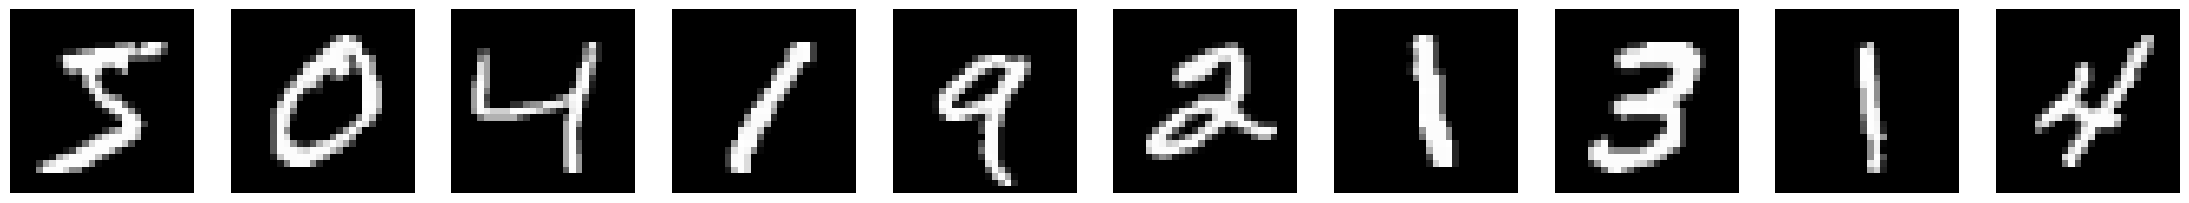

In [7]:
show_mnist_images(all_images_data = train_images[:10], current_range=(-1, 1))

In [8]:
num_train_real_data_items = train_images.shape[0]
num_test_real_data_items = test_images.shape[0]

In [9]:
latent_space_size = 6

In [10]:
# # continuous output
output_function_decoder = "tanh"
ouput_range_decoder = (-1, 1)

# output_function_decoder = "sigmoid"
# ouput_range_decoder = (0, 1)

loss_function_model_image_output = "MSE",
metric_model_image_output = "MSE"


# # discrete output
# output_function_decoder = "sigmoid"
# ouput_range_decoder = (0, 1)

# loss_function_model_image_output = "binary_crossentropy"
# metric_model_image_output = "accuracy"

In [11]:
input_image_shape = (28, 28, 1)
input_image_vector_size = input_image_shape[0] * input_image_shape[1]

In [12]:
# autoencoder_max_epochs = 30
# autoencoder_min_loss_change = 10**-3
# autoencoder_loss_patience = 4

autoencoder_max_epochs = 25
autoencoder_min_loss_change = 10**-4
autoencoder_loss_patience = 8

autoencoder_use_all_data = True

activation_funcion_factory_autoencoder = lambda: Activation("ReLU")

use_normalisation_autoencoder = False
use_dropout_autoencoder = True
dropout_rate_autoencoder = 0.4

# hidden_neurons_per_hidden_layer = [200, 100, 50]
# hidden_neurons_per_hidden_layer = [100, 50]
hidden_neurons_per_hidden_layer = [200, 100]
# hidden_neurons_per_hidden_layer = [50, 20]

# hidden_neurons_per_hidden_layer = [100,]

encoder_neurons_per_hidden_layer = hidden_neurons_per_hidden_layer
decoder_neurons_per_hidden_layer = list(reversed(hidden_neurons_per_hidden_layer))

In [13]:
# perceptron_max_epochs = 30
# perceptron_min_loss_change = 10**-3
# perceptron_loss_patience = 4

perceptron_max_epochs = 25
perceptron_min_loss_change = 10**-4
perceptron_loss_patience = 8

perceptron_use_all_data = True

activation_funcion_factory_latent_classifier = lambda: Activation("ReLU")

use_normalisation_latent_classifier = False
use_dropout_latent_classifier = True
dropout_rate_latent_classifier = 0.4

# latent_classifier_neurons = [20, 20]
latent_classifier_neurons = [100, 100]

# perceptron is encoder + latent classifier. This trains latent classifier 

In [14]:
latent_generator_training_data_size = 7*10**3

# latent_generator_max_epochs = 30
# latent_generator_min_loss_change = 10**-3
# latent_generator_loss_patience = 4

latent_generator_max_epochs = 50
latent_generator_min_loss_change = 10**-4
latent_generator_loss_patience = 8

activation_funcion_factory_latent_generator = lambda: Activation("ReLU")

use_normalisation_latent_generator = False
use_dropout_latent_generator = True
dropout_rate_generator = 0.4

latent_generator_random_seed_size = 25

# latent_classifier_neurons = [20, 20]
latent_generator_neurons = [100, 100]


In [15]:
model_encoder = Sequential()

model_encoder.add(Input(input_image_shape))
model_encoder.add(Flatten())

# if use_normalisation:
#     model_encoder.add(BatchNormalization())

for hidden_layer_num_neurons in encoder_neurons_per_hidden_layer:
    model_encoder.add(Dense(hidden_layer_num_neurons))

    model_encoder.add(activation_funcion_factory_autoencoder())

    if use_normalisation_autoencoder:
        model_encoder.add(BatchNormalization())

    if use_dropout_autoencoder:
        model_encoder.add(Dropout(dropout_rate_autoencoder))


model_encoder.add(Dense(latent_space_size))

# outpoust can be of any range as they are then normalised
# model_encoder.add(Activation("tanh"))

# make the latent space vecotors distributed with standard normal
model_encoder.add(BatchNormalization())

model_encoder.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mean_squared_error']
)

In [16]:
model_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 200)               157000    
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dropout_1 (Dropout)         (None, 100)               0

In [17]:
model_decoder = Sequential()

model_decoder.add(Input(latent_space_size))

# if use_normalisation:
#     model_encoder.add(BatchNormalization())

for hidden_layer_num_neurons in decoder_neurons_per_hidden_layer:
    model_decoder.add(Dense(hidden_layer_num_neurons))

    model_decoder.add(activation_funcion_factory_autoencoder())

    if use_normalisation_autoencoder:
        model_decoder.add(BatchNormalization())

    if use_dropout_autoencoder:
        model_decoder.add(Dropout(dropout_rate_autoencoder))

model_decoder.add(Dense(input_image_vector_size))

model_decoder.add(Activation(output_function_decoder))

model_decoder.add(Reshape(input_image_shape))


model_decoder.compile(
    optimizer='adam', 
    loss=loss_function_model_image_output,
    metrics=[metric_model_image_output,]
)

In [18]:
model_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               700       
                                                                 
 activation_2 (Activation)   (None, 100)               0         
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               20200     
                                                                 
 activation_3 (Activation)   (None, 200)               0         
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 784)              

In [19]:
autoencoder_input = Input(input_image_shape)

normalised_latent_vector = model_encoder(autoencoder_input)
decoded_output = model_decoder(normalised_latent_vector)

model_autoencoder = Model(autoencoder_input, decoded_output)

In [20]:
model_autoencoder.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 6)                 177730    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| flatten (Flatten)          (None, 784)               0        |
|                                                               |
| dense (Dense)              (None, 200)               157000   |
|                                                               |
| activation (Activation)    (None, 200)               0        |
|                                                               |
| dropout (Dropout)          (None, 200)               0        |
|                                                               |
| dense_1 (Dense)            (None, 100)               20100 

In [21]:
model_autoencoder.compile(
    optimizer='adam', 
    loss=loss_function_model_image_output,
    metrics=[metric_model_image_output,]
)

In [22]:
num_predictions = 10
predictions = model_autoencoder.predict(train_images[:num_predictions])

1/1 [==============================] - 2s 2s/step


In [23]:
assert predictions.shape == (num_predictions, 28, 28, 1)

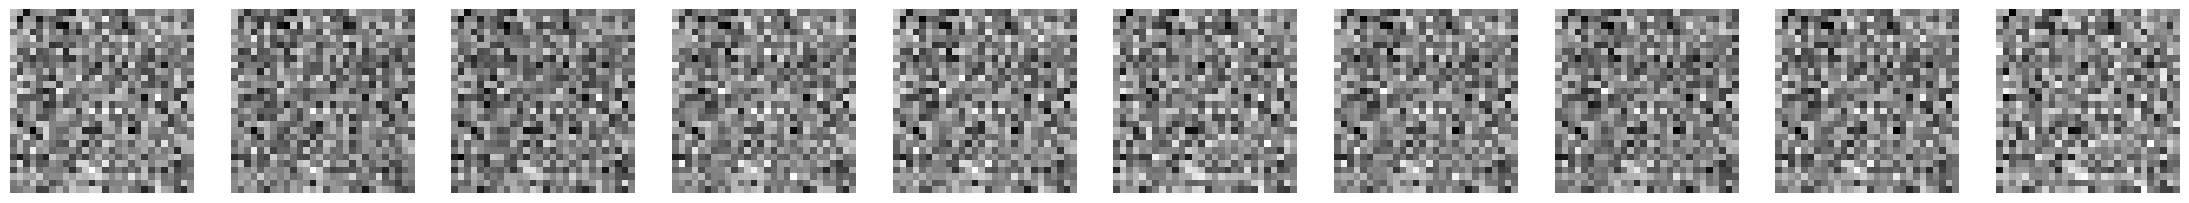

In [24]:
show_mnist_images(
    all_images_data=predictions,
    current_range=(0, 1)
)

In [25]:
def display_model_recreations(num_items):
    real_input_images = train_images[:num_items]
    real_predictions = model_autoencoder.predict(real_input_images)

    # latent space vectors distributed with standard normal not uniform
    # fake_latent_vectors = np.random.uniform(-1, 1, size=(num_items, latent_space_size))
    fake_latent_vectors = np.random.randn(num_items, latent_space_size)


    fake_images = model_decoder.predict(fake_latent_vectors)

    # fake_images_reprocessed = model_autoencoder.predict(fake_images)


    fake_images_multi_reprocessed = fake_images
    num_reprocessing = 10
    for _ in range(num_reprocessing):
        fake_images_multi_reprocessed = model_autoencoder.predict(fake_images_multi_reprocessed)

    print(f"Model input images:")
    show_mnist_images(
        all_images_data=real_input_images,
        current_range=image_input_range
    )


    print("Combined model output:")
    show_mnist_images(
        all_images_data=real_predictions,
        current_range=ouput_range_decoder
    )

    print("Generated images:")
    show_mnist_images(
        all_images_data=fake_images,
        current_range=ouput_range_decoder
    )

    # print("Generated images reprocessed through autoencoder:")
    # show_mnist_images(
    #     all_images_data=fake_images_reprocessed,
    #     current_range=ouput_range_decoder
    # )

    print("Generated images reprocessed through autoencoder many times:")
    show_mnist_images(
        all_images_data=fake_images_multi_reprocessed,
        current_range=ouput_range_decoder
    )



1/1 [==============================] - 0s 164ms/step
Model input images:


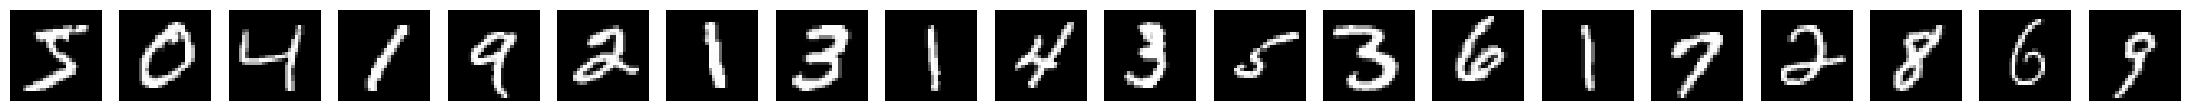

Combined model output:


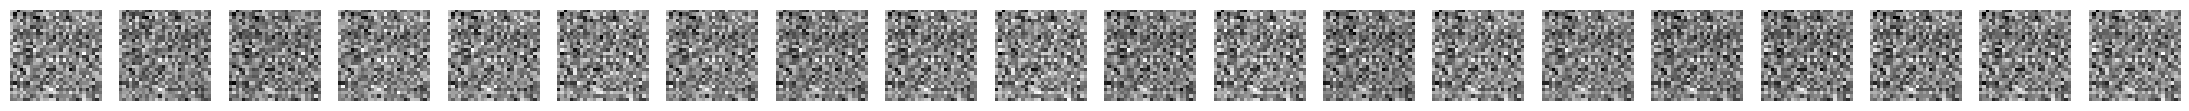

Generated images:


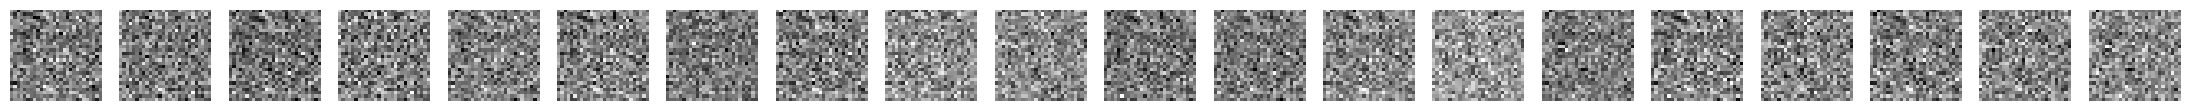

Generated images reprocessed through autoencoder many times:


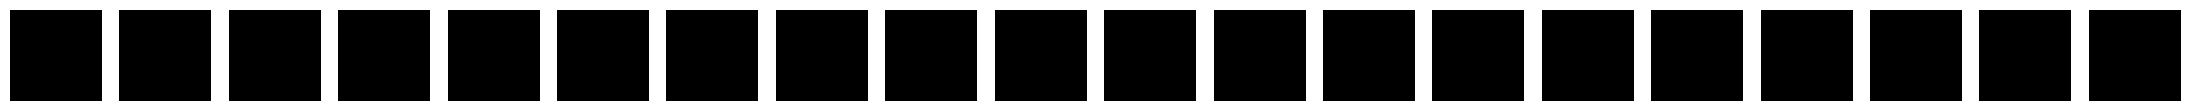

In [26]:
display_model_recreations(20)

In [27]:
model_autoencoder.evaluate(x=test_images, y=test_images)



313/313 [==============================] - 9s 15ms/step - loss: 0.9304 - MSE: 0.9304


[0.9303709268569946, 0.9303717613220215]

In [28]:
early_stopping_autoencoder = EarlyStopping(
    monitor='val_loss',
    min_delta=autoencoder_min_loss_change / autoencoder_loss_patience, 
    patience=autoencoder_loss_patience, 
    verbose=2, 
    restore_best_weights=True
)

if autoencoder_use_all_data:
    images_data_autoencoder = train_images
else:
    images_data_autoencoder = all_images

model_autoencoder.fit(
    x=images_data_autoencoder,
    y=images_data_autoencoder,
    batch_size = 50,
    epochs = autoencoder_max_epochs,
    verbose = 2,
    validation_split = 0.25,
    callbacks=[early_stopping_autoencoder,]
)

Epoch 1/25
900/900 - 34s - loss: 0.2292 - MSE: 0.2292 - val_loss: 0.1611 - val_MSE: 0.1611 - 34s/epoch - 38ms/step
Epoch 2/25
900/900 - 13s - loss: 0.1798 - MSE: 0.1798 - val_loss: 0.1424 - val_MSE: 0.1424 - 13s/epoch - 14ms/step
Epoch 3/25
900/900 - 22s - loss: 0.1713 - MSE: 0.1713 - val_loss: 0.1379 - val_MSE: 0.1379 - 22s/epoch - 24ms/step
Epoch 4/25
900/900 - 17s - loss: 0.1674 - MSE: 0.1674 - val_loss: 0.1342 - val_MSE: 0.1342 - 17s/epoch - 19ms/step
Epoch 5/25
900/900 - 12s - loss: 0.1650 - MSE: 0.1650 - val_loss: 0.1321 - val_MSE: 0.1321 - 12s/epoch - 14ms/step
Epoch 6/25
900/900 - 12s - loss: 0.1630 - MSE: 0.1630 - val_loss: 0.1299 - val_MSE: 0.1299 - 12s/epoch - 13ms/step
Epoch 7/25
900/900 - 13s - loss: 0.1617 - MSE: 0.1617 - val_loss: 0.1290 - val_MSE: 0.1290 - 13s/epoch - 15ms/step
Epoch 8/25
900/900 - 8s - loss: 0.1607 - MSE: 0.1607 - val_loss: 0.1288 - val_MSE: 0.1288 - 8s/epoch - 9ms/step
Epoch 9/25
900/900 - 7s - loss: 0.1599 - MSE: 0.1599 - val_loss: 0.1274 - val_MSE: 

In [29]:
model_autoencoder.evaluate(x=test_images, y=test_images)

313/313 [==============================] - 1s 4ms/step - loss: 0.1226 - MSE: 0.1226


[0.12262806296348572, 0.12262804061174393]

1/1 [==============================] - 0s 72ms/step
Model input images:


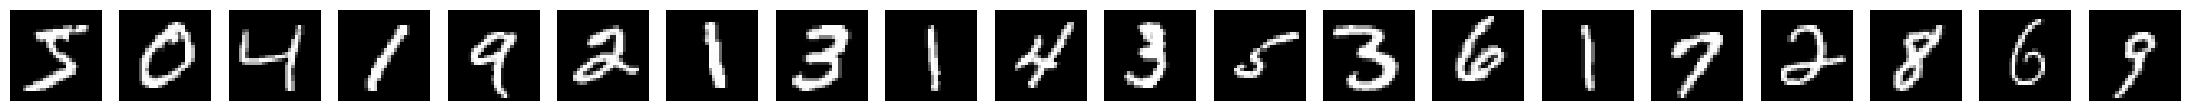

Combined model output:


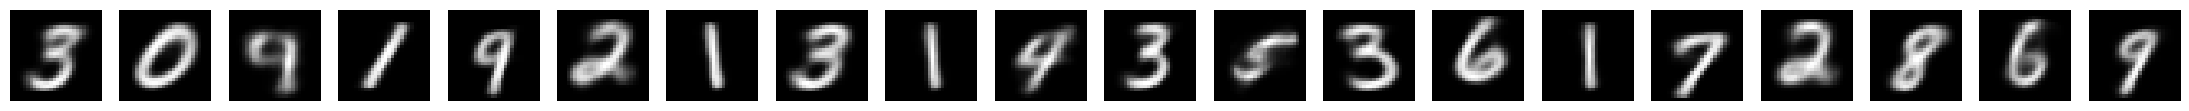

Generated images:


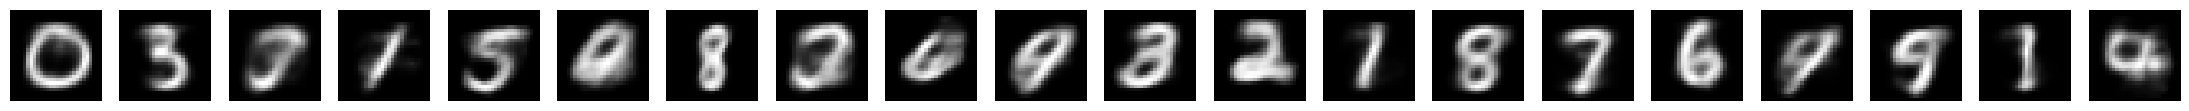

Generated images reprocessed through autoencoder many times:


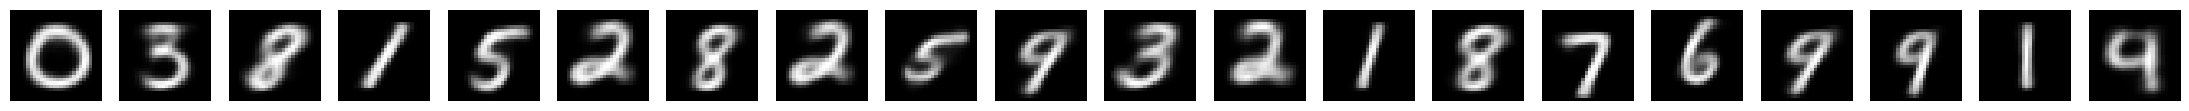

In [30]:
display_model_recreations(20)

In [31]:
model_latent_classifier = Sequential()

model_latent_classifier.add(Input(latent_space_size))

for num_layer_neurons in latent_classifier_neurons:

    model_latent_classifier.add(Dense(num_layer_neurons))
    model_latent_classifier.add(activation_funcion_factory_latent_classifier())

    if use_normalisation_latent_classifier:
        model_latent_classifier.add(BatchNormalization())

    
    if use_dropout_latent_classifier:
        model_latent_classifier.add(Dropout(dropout_rate_latent_classifier))

model_latent_classifier.add(Dense(10))
model_latent_classifier.add(Softmax())


In [32]:
autoencoder_input = Input(input_image_shape)

encoded_features = model_encoder(autoencoder_input)

perceptron_output = model_latent_classifier(encoded_features)

model_perceptron = Model(autoencoder_input, perceptron_output)

In [33]:
model_perceptron.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',]
)

In [34]:
model_perceptron.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 4ms/step - loss: 2.3664 - accuracy: 0.0921


[2.3664391040802, 0.09210000187158585]

In [35]:
early_stopping_perceptron = EarlyStopping(
    monitor='val_loss',
    min_delta=perceptron_min_loss_change / perceptron_loss_patience, 
    patience=perceptron_loss_patience, 
    verbose=2, 
    restore_best_weights=True
)

model_encoder.trainable = False

if perceptron_use_all_data:
    x_data_perceptron = all_images
    y_data_perceptron = all_labels
else: 
    x_data_perceptron = train_images
    y_data_perceptron = train_labels

model_perceptron.fit(
    x=x_data_perceptron,
    y=y_data_perceptron,
    batch_size=50,
    epochs = perceptron_max_epochs,
    verbose = 2,
    validation_split = 0.25,
    callbacks=[early_stopping_perceptron,]
)
model_encoder.trainable = True

Epoch 1/25
1050/1050 - 12s - loss: 0.8391 - accuracy: 0.7250 - val_loss: 0.3178 - val_accuracy: 0.9045 - 12s/epoch - 12ms/step
Epoch 2/25
1050/1050 - 13s - loss: 0.5301 - accuracy: 0.8396 - val_loss: 0.2341 - val_accuracy: 0.9313 - 13s/epoch - 12ms/step
Epoch 3/25
1050/1050 - 24s - loss: 0.4595 - accuracy: 0.8653 - val_loss: 0.2098 - val_accuracy: 0.9378 - 24s/epoch - 23ms/step
Epoch 4/25
1050/1050 - 15s - loss: 0.4231 - accuracy: 0.8811 - val_loss: 0.1847 - val_accuracy: 0.9452 - 15s/epoch - 14ms/step
Epoch 5/25
1050/1050 - 9s - loss: 0.3900 - accuracy: 0.8912 - val_loss: 0.1692 - val_accuracy: 0.9491 - 9s/epoch - 8ms/step
Epoch 6/25
1050/1050 - 8s - loss: 0.3673 - accuracy: 0.8973 - val_loss: 0.1711 - val_accuracy: 0.9508 - 8s/epoch - 8ms/step
Epoch 7/25
1050/1050 - 9s - loss: 0.3575 - accuracy: 0.9008 - val_loss: 0.1643 - val_accuracy: 0.9523 - 9s/epoch - 8ms/step
Epoch 8/25
1050/1050 - 12s - loss: 0.3459 - accuracy: 0.9046 - val_loss: 0.1517 - val_accuracy: 0.9555 - 12s/epoch - 11m

In [36]:
if not perceptron_use_all_data:
    model_perceptron.evaluate(test_images, test_labels)

In [37]:
def get_most_likley_and_p_from_distributions(perceptron_distributions):
    produced_outputs = []
    for distribution in perceptron_distributions:
        max_probability = distribution[0]
        max_label = 0
        for label, probability in enumerate(distribution):
            if probability > max_probability:
                max_probability = probability
                max_label = label
        produced_outputs.append(f"P({max_label})={max_probability:.4f}")

    # seperator_characters = (
    #     "\n" if i % 10 == 9 else ";  " 
    #     for i in range(perceptron_distributions.shape[1])
    # )
    

    produced_outputs = "\n".join(produced_outputs)

    return produced_outputs

In [38]:
def get_most_likley_and_p_from_images(digits_data):
    return get_most_likley_and_p_from_distributions(
        model_perceptron.predict(digits_data)
    )


In [39]:
def get_most_likley_and_p_from_latent_vectors(latent_vectors_data):
    return get_most_likley_and_p_from_distributions(
        model_latent_classifier.predict(latent_vectors_data)
    )

In [40]:
def display_generated_digits_catagorised(real_input_images, fake_latent_vectors):
    real_predictions = model_autoencoder.predict(real_input_images)

    fake_images = model_decoder.predict(fake_latent_vectors)

    fake_images_reprocessed = model_autoencoder.predict(fake_images)


    fake_images_multi_reprocessed = fake_images
    num_reprocessing = 5
    for _ in range(num_reprocessing):
        fake_images_multi_reprocessed = model_autoencoder.predict(fake_images_multi_reprocessed)

    print(f"Model input images:")
    show_mnist_images(
        all_images_data=real_input_images,
        current_range=image_input_range
    )
    print("Perceptron max probabilites")
    print(get_most_likley_and_p_from_images(real_input_images))


    print("Combined model output:")
    show_mnist_images(
        all_images_data=real_predictions,
        current_range=ouput_range_decoder
    )
    print("Perceptron max probabilites")
    print(get_most_likley_and_p_from_images(real_predictions))


    print("\nPreliminary fake token classifications")
    print(get_most_likley_and_p_from_latent_vectors(fake_latent_vectors))

    print("\nGenerated images:")
    show_mnist_images(
        all_images_data=fake_images,
        current_range=ouput_range_decoder
    )
    print("Perceptron max probabilites")
    print(get_most_likley_and_p_from_images(fake_images))

    print("Generated images reprocessed through autoencoder:")
    show_mnist_images(
        all_images_data=fake_images_reprocessed,
        current_range=ouput_range_decoder
    )
    print("Perceptron max probabilites")
    print(get_most_likley_and_p_from_images(fake_images_reprocessed))

    # print("Generated images reprocessed through autoencoder many times:")
    # show_mnist_images(
    #     all_images_data=fake_images_multi_reprocessed,
    #     current_range=ouput_range_decoder
    # )
    # print("Perceptron max probabilites on image")
    # print(get_most_likley_and_p_from_images(fake_images_multi_reprocessed))



In [41]:
def create_good_fake_latent_vectors(max_pool_size = 100):
    fake_latent_vectors = []
    
    potential_fake_latent_vectors = np.random.uniform(-1, 1, size=(max_pool_size, latent_space_size))
    probability_distributions = model_latent_classifier.predict(potential_fake_latent_vectors)
    for desired_didgit in range(10):
        best_p_desired_didgit = -1
        best_index = -1
        for i in range(max_pool_size):
            p_desired_didgit = probability_distributions[i][desired_didgit]
            if p_desired_didgit > best_p_desired_didgit:
                best_p_desired_didgit = p_desired_didgit
                best_index = i

        fake_latent_vectors.append(potential_fake_latent_vectors[best_index])

    fake_latent_vectors = np.array(fake_latent_vectors)

    return fake_latent_vectors    



In [42]:
def display_generated_digits_catagorised_20_reals_and_fakes():

    display_generated_digits_catagorised(
        real_input_images = train_images[:20],
        fake_latent_vectors = np.concatenate(
            [
                create_good_fake_latent_vectors(max_pool_size=10**4)
                for _ in range(2)
            ],
            axis=0
        )
    )


1/1 [==============================] - 0s 35ms/step
Model input images:


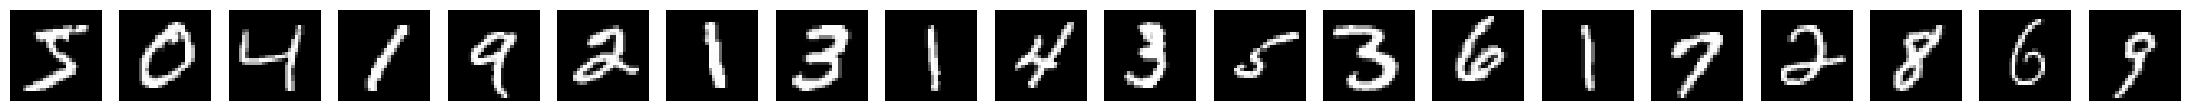

Perceptron max probabilites
1/1 [==============================] - 0s 231ms/step
P(5)=0.7726
P(0)=0.9996
P(4)=0.9691
P(1)=0.9998
P(9)=0.9964
P(2)=0.9692
P(1)=1.0000
P(3)=1.0000
P(1)=0.9999
P(4)=0.9868
P(3)=0.9999
P(5)=0.9973
P(3)=1.0000
P(6)=0.9986
P(1)=0.9999
P(7)=0.9963
P(2)=0.9761
P(8)=0.9980
P(6)=0.9819
P(9)=0.9582
Combined model output:


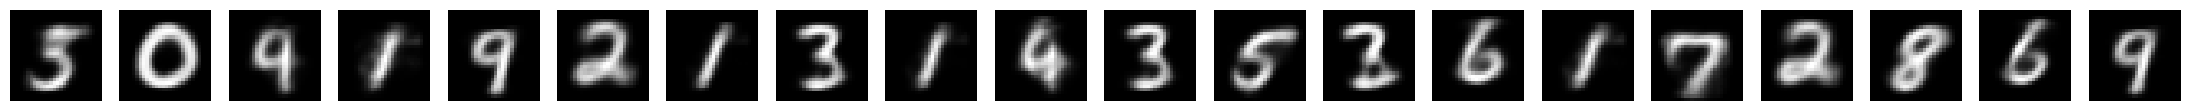

Perceptron max probabilites
1/1 [==============================] - 0s 301ms/step
P(5)=0.8296
P(0)=0.9994
P(4)=0.9285
P(1)=0.9236
P(9)=0.9877
P(2)=0.9951
P(1)=0.9982
P(3)=0.9998
P(1)=0.9923
P(4)=0.7384
P(3)=0.9997
P(5)=0.9986
P(3)=0.9994
P(6)=0.9960
P(1)=0.9836
P(7)=0.9930
P(2)=0.9962
P(8)=0.9933
P(6)=0.9970
P(9)=0.9786

Preliminary fake token classifications
1/1 [==============================] - 0s 55ms/step
P(0)=0.9969
P(1)=0.9991
P(2)=0.9956
P(3)=0.9991
P(4)=0.9918
P(5)=0.9973
P(6)=0.9929
P(7)=0.9947
P(8)=0.9973
P(9)=0.9908
P(0)=0.9960
P(1)=0.9980
P(2)=0.9963
P(3)=0.9994
P(4)=0.9923
P(5)=0.9979
P(6)=0.9932
P(7)=0.9934
P(8)=0.9977
P(9)=0.9953

Generated images:


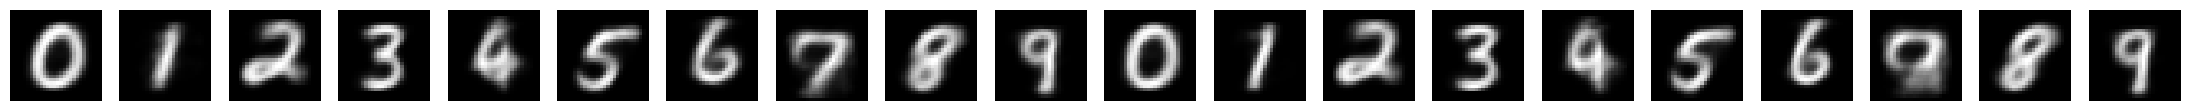

Perceptron max probabilites
1/1 [==============================] - 0s 49ms/step
P(0)=0.9949
P(1)=0.9560
P(2)=0.9982
P(3)=0.9994
P(6)=0.7629
P(5)=0.9997
P(6)=0.9953
P(7)=0.9682
P(8)=0.9892
P(9)=0.9749
P(0)=0.9930
P(1)=0.9914
P(2)=0.9984
P(3)=0.9996
P(4)=0.8415
P(5)=0.9993
P(6)=0.9975
P(9)=0.7448
P(8)=0.9890
P(9)=0.9848
Generated images reprocessed through autoencoder:


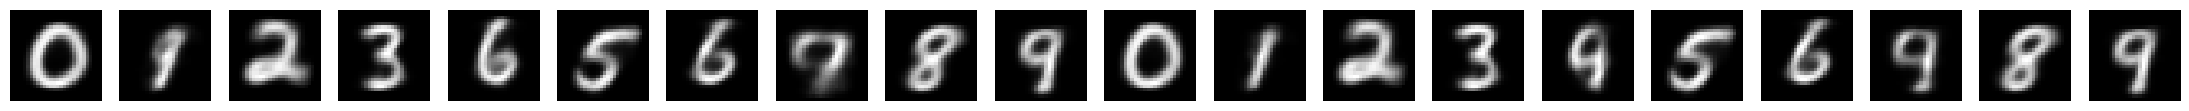

Perceptron max probabilites
1/1 [==============================] - 0s 66ms/step
P(0)=0.9978
P(9)=0.6110
P(2)=0.9988
P(3)=0.9990
P(6)=0.9872
P(5)=0.9993
P(6)=0.9971
P(7)=0.7385
P(8)=0.9934
P(9)=0.9750
P(0)=0.9973
P(1)=0.9376
P(2)=0.9989
P(3)=0.9991
P(4)=0.7810
P(5)=0.9990
P(6)=0.9984
P(9)=0.9188
P(8)=0.9929
P(9)=0.9823


In [43]:
display_generated_digits_catagorised_20_reals_and_fakes()

In [44]:
inner_model_conditional_latent_generator = Sequential()

# label for didgit + random seed
latent_generator_input_neurons = 10 + latent_generator_random_seed_size
inner_model_conditional_latent_generator.add(Input(latent_generator_input_neurons))

for num_layer_neurons in latent_classifier_neurons:

    inner_model_conditional_latent_generator.add(Dense(num_layer_neurons))
    inner_model_conditional_latent_generator.add(activation_funcion_factory_latent_generator())

    if use_normalisation_latent_generator:
        inner_model_conditional_latent_generator.add(BatchNormalization())

    if use_dropout_latent_generator:
        inner_model_conditional_latent_generator.add(Dropout(0.4))

inner_model_conditional_latent_generator.add(Dense(latent_space_size))
inner_model_conditional_latent_generator.add(BatchNormalization())

In [45]:
# make model model_conditional_latent_generator
# maps label of didgit to a latent vector

latent_generator_conditional_label_input = Input(10)

def random_seed_creator_standard_normal(seed_size):
    return tf.random.normal(
        shape = (
            seed_size,
            latent_generator_random_seed_size
        )
    )

def random_seed_creator_uniform(seed_size):
    return tf.random.uniform(
        minval = -1, 
        maxval = 1,
        shape = (
            seed_size, 
            latent_generator_random_seed_size
        )
    )


random_seed = tf.keras.layers.Lambda(
    # lambda x: random_seed_creator_standard_normal(tf.shape(x)[0])
    lambda x: random_seed_creator_uniform(tf.shape(x)[0])
)(latent_generator_conditional_label_input)

combined_input_inner_model_conditional_latent_generator = Concatenate()([latent_generator_conditional_label_input, random_seed])


output_inner_model_conditional_latent_generator = inner_model_conditional_latent_generator(combined_input_inner_model_conditional_latent_generator)

model_conditional_latent_generator = Model(latent_generator_conditional_label_input, output_inner_model_conditional_latent_generator)

model_conditional_latent_generator.compile(
    optimizer='adam',
    loss='MSE',
    metrics=['MSE',]
)

In [46]:
# create model_latent_generator_classifier_composition

input_model_conditional_latent_generator = Input(10)

output_model_latent_generator = model_conditional_latent_generator(input_model_conditional_latent_generator)

output_model_latent_classifier = model_latent_classifier(output_model_latent_generator)


model_latent_generator_classifier_composition = Model(input_model_conditional_latent_generator, output_model_latent_classifier)

model_latent_generator_classifier_composition.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',]
)

In [47]:
# create model_conditional_image_generator

input_model_conditional_latent_generator = Input(10)

output_model_latent_generator = model_conditional_latent_generator(input_model_conditional_latent_generator)

output_model_decoder = model_decoder(output_model_latent_generator)


model_conditional_image_generator = Model(input_model_conditional_latent_generator, output_model_decoder)

model_conditional_image_generator.compile(
    optimizer='adam',
    loss=loss_function_model_image_output,
    metrics=[metric_model_image_output,]
)

In [48]:
# make training data

# input output pairs will just be one hot lables for the mnist items
# use duplicate labels for each of 0 to 9

training_data_set_size = 5*10**3

labels = to_categorical(
    np.repeat(
        np.arange(10),
        training_data_set_size // 10
    )
)
np.random.shuffle(labels)

In [49]:
early_stopping_generator = EarlyStopping(
    monitor='val_loss',
    min_delta=latent_generator_min_loss_change / latent_generator_loss_patience, 
    patience=latent_generator_loss_patience , 
    verbose=2, 
    restore_best_weights=True
)


# train model_latent_generator_classifier_composition

model_latent_classifier.trainable = False

# all the data is just a single batch 
model_latent_generator_classifier_composition.fit(
    x=labels,
    y=labels,
    epochs=latent_generator_max_epochs,
    batch_size=50,
    verbose = 2,
    validation_split = 0.25,
    callbacks=[early_stopping_generator,]

)

model_latent_classifier.trainable = True


Epoch 1/50
75/75 - 3s - loss: 4.0772 - accuracy: 0.1477 - val_loss: 2.0001 - val_accuracy: 0.2976 - 3s/epoch - 46ms/step
Epoch 2/50
75/75 - 0s - loss: 2.2270 - accuracy: 0.2416 - val_loss: 1.7640 - val_accuracy: 0.5312 - 330ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 1.8941 - accuracy: 0.3301 - val_loss: 1.3920 - val_accuracy: 0.7528 - 355ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 1.6314 - accuracy: 0.4413 - val_loss: 0.8152 - val_accuracy: 0.9376 - 418ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 1.2081 - accuracy: 0.6013 - val_loss: 0.3085 - val_accuracy: 0.9912 - 475ms/epoch - 6ms/step
Epoch 6/50
75/75 - 1s - loss: 0.8196 - accuracy: 0.7280 - val_loss: 0.0804 - val_accuracy: 1.0000 - 606ms/epoch - 8ms/step
Epoch 7/50
75/75 - 1s - loss: 0.5069 - accuracy: 0.8440 - val_loss: 0.0176 - val_accuracy: 1.0000 - 581ms/epoch - 8ms/step
Epoch 8/50
75/75 - 1s - loss: 0.3146 - accuracy: 0.8987 - val_loss: 0.0064 - val_accuracy: 1.0000 - 556ms/epoch - 7ms/step
Epoch 9/50
75/75 -

In [50]:
def display_20_latent_generator_digits():
    image_numbers = np.repeat(
        np.arange(10),
        2
    )
    image_labels = to_categorical(image_numbers)  


    fake_images = model_conditional_image_generator.predict(image_labels)

    # fake_images_reprocessed = model_autoencoder.predict(fake_images)

    fake_images_multi_reprocessed = fake_images
    num_reprocessing = 5
    for _ in range(num_reprocessing):
        fake_images_multi_reprocessed = model_autoencoder.predict(fake_images_multi_reprocessed)


    print("Numbers that should be generated:")
    print(", ".join(str(num) for num in image_numbers))

    print("Generated images:")
    show_mnist_images(
        all_images_data=fake_images,
        current_range=ouput_range_decoder
    )
    print("Perceptron max probabilites")
    print(get_most_likley_and_p_from_images(fake_images))

    # print("Generated images reprocessed through autoencoder:")
    # show_mnist_images(
    #     all_images_data=fake_images_reprocessed,
    #     current_range=ouput_range_decoder
    # )
    # print("Perceptron max probabilites")
    # print(get_most_likley_and_p_from_images(fake_images_reprocessed))

    # print("Generated images reprocessed through autoencoder many times:")
    # show_mnist_images(
    #     all_images_data=fake_images_multi_reprocessed,
    #     current_range=ouput_range_decoder
    # )
    # print("Perceptron max probabilites on image")
    # print(get_most_likley_and_p_from_images(fake_images_multi_reprocessed))



1/1 [==============================] - 0s 39ms/step
Numbers that should be generated:
0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9
Generated images:


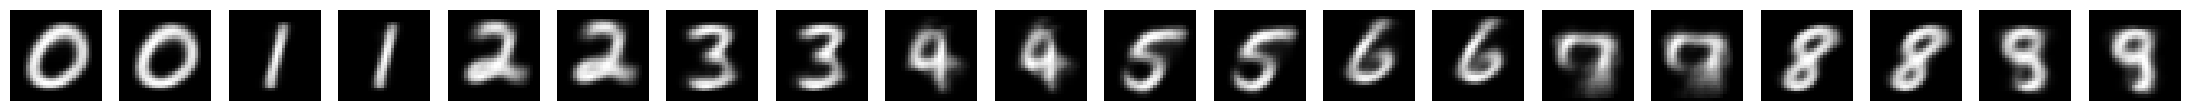

Perceptron max probabilites
1/1 [==============================] - 0s 27ms/step
P(0)=1.0000
P(0)=1.0000
P(1)=1.0000
P(1)=1.0000
P(2)=1.0000
P(2)=1.0000
P(3)=1.0000
P(3)=1.0000
P(4)=0.9957
P(4)=0.9843
P(5)=1.0000
P(5)=1.0000
P(6)=1.0000
P(6)=1.0000
P(7)=0.9976
P(7)=0.9951
P(8)=1.0000
P(8)=1.0000
P(8)=0.9961
P(9)=0.9860


In [51]:
display_20_latent_generator_digits()

This is great, and I'm pretty proud of it. But obviously the issue is that the latent generator is over fitting to the latent classifier. The solution to this would be to. train the latent classifier off the latent generator. I was hoping to avoid this because I find gans and modal claps really tricky to deal with. However, I now see that. continuing to train the late and generator off the latent classifier will essentially always result in the late and generator over fitting for the latent classifier. It can choose to ignore the random noise by assigning very low weights to it and it can. essentially choose to choose depending on the one hot input 1 of 10 different vectors to output which are essentially the Argmax values for inputs which maximise a certain probability over fitting the classifier.. if I train both of them off each other, I don't want to have an issue where the classifier starts. going all haywire and identifying things that clearly aren't images of numbers as numbers. I wonder if I can pretrain it with the real data and then train it off the generator from there. Alternative alternatively, perhaps I can train the generator using two versions of the classifier. I could do this by training the classifier just on the real data, then copying it, then having an adversarial approach with a generator and a new classifier train off each other, but the generators loss has a component in it. weighted sum, which is the original real only classifier ensuring. that in order to do well, it has to satisfy the original classifier reasonably well and satisfy the new classifier.. but I don't worry. I'm just adding complexity here This investigation was interesting though, and I think the idea of having more complex problems such as perceptions for classification or generators for generation abstracting away the pattern down to a much simpler, dense vector which can be encoded and decoded to the original pattern is a really valuable thing.. I want to continue to explore the idea and most people don't know that this idea is flawed in this way so I'm still pretty proud of what I've done, even though I've identified the issue with it.

I have a few ideas for improving this main. one is I want to try and move the size of the latent space to change it to be smaller so that. the task for the generator is easier The second idea is I need to try and adapt the mechanism for training the generator so it's not just over fitting from the classifier Perhaps I could do this by either making it so that I stop the generator's training early before it really perfects exploiting the classifier. However, this might be flawed as it might make bad digits. I could also try making it so that it gets no extra benefit from achieving 80% probability versus 100% probability from the classifier. However, this again might have it create bad digits. The other thing I could try is. to try and train the classifier along with the generator. I could potentially try training the classifier first and training the generator to the classifier for a bit and then when it's starting to get good start training a classifier too. I could also potentially try after training the classifier on reels, making a copy of it, which is separate and then. the copy trains with the generator and the generator uses the loss function for weighted sum of the original real only trained classifier and the classifier that trains with the generator This would hopefully encourage the generator to learn to produce things that the real only classifier identifies as digits, forcing it to not overexploit the training with classified to produce non digits, but also forcing it to deal with the adversarial training. with classifier which will try and learn as well. I don't know if this would work though, because I'm deviating from the whole idea of discriminator.